In [27]:
import ezc3d
import numpy as np
import json
import pandas as pd
import pickle
import os
from io import StringIO

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp

import ipywidgets as widgets
from ipywidgets import interact,FloatSlider,IntSlider,interactive,HBox
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

In [28]:
def read_trc_to_dataframe(trc_path):
    """
    Reads a TRC file with multiple header lines into a Pandas DataFrame.
    Returns the DataFrame.
    
    Assumes a format like:
      1) PathFileType line
      2) DataRate line
      3) #Frame   Time   Marker1   Marker2 ...
      4) [blank]  [blank]  X1  Y1  Z1   X2  Y2  Z2  ...
      5+) numeric data lines

    Adjust skip logic if your TRC differs.
    """
    with open(trc_path, 'r') as f:
        lines = [l.strip('\n') for l in f.readlines()]
    
    # 1. Find the line that starts with "#Frame" or "Frame#"
    data_start_idx = None
    for i, line in enumerate(lines):
        if line.startswith("#Frame") or line.startswith("Frame#"):
            data_start_idx = i
            break
    if data_start_idx is None:
        raise ValueError("Could not find a line starting with '#Frame' or 'Frame#' in the TRC file.")
    
    # 2. We expect the row with X1, Y1, Z1 to be right after that (data_start_idx+1).
    #    Then numeric data starts at (data_start_idx+2).
    header_line_1 = lines[data_start_idx].split()     # e.g. ['#Frame', 'Time', 'Marker1', 'Marker2', ...]
    header_line_2 = lines[data_start_idx+1].split()   # e.g. ['', '', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', ...]
    
    # 3. Combine header_line_1 and header_line_2 to form final column names.
    #    For example:
    #      #Frame  Time  Marker1  Marker2
    #      ""      ""    X1       Y1 ...
    #    => columns = [Frame, Time, Marker1_X, Marker1_Y, Marker1_Z, Marker2_X, ...]
    
    columns = []
    # The assumption: the first two entries are #Frame, Time; second row for those is blank.
    # After that, we pair up MarkerX name with X1/Y1/Z1 from header_line_2.
    
    # For safety, ensure both lines have the same length by padding if needed:
    max_len = max(len(header_line_1), len(header_line_2))
    col1 = (header_line_1 + [""]*(max_len - len(header_line_1)))[:max_len]
    col2 = (header_line_2 + [""]*(max_len - len(header_line_2)))[:max_len]
    
    for c1, c2 in zip(col1, col2):
        c1 = c1.strip()
        c2 = c2.strip()
        
        # If it's the #Frame or Frame#
        if c1.startswith("#Frame") or c1.startswith("Frame#"):
            columns.append("Frame")
        # If it's Time
        elif c1 == "Time":
            columns.append("Time")
        # If c1 is a marker name (like "Marker1") and c2 is dimension ("X1", "Y1", "Z1")
        elif c1 and c2 and c2[0] in ["X", "Y", "Z"]:
            # e.g. 'Marker1' and 'X1' => 'Marker1_X'
            marker_dim = c2[0]  # 'X' or 'Y' or 'Z'
            new_name = f"{c1}_{marker_dim}"
            columns.append(new_name)
        else:
            # Otherwise, maybe blank or unknown
            # We'll still append something to keep column count aligned
            columns.append(c1 if c1 else c2)
    
    # 4. Now read the numeric data using read_csv, skipping all lines up to data_start_idx+2
    numeric_start = data_start_idx + 2
    df = pd.read_csv(
        trc_path, 
        sep=r'\s+|\t+',   # split on whitespace or tabs
        engine='python', 
        skiprows=numeric_start, 
        header=None
    )
    
    # 5. Trim or pad columns if needed
    if len(df.columns) > len(columns):
        df = df.iloc[:, :len(columns)]
    elif len(df.columns) < len(columns):
        columns = columns[:len(df.columns)]
    
    df.columns = columns
    
    return df


def read_trc_and_header_to_json(trc_file_path):
    """
    Reads a TRC file with a 4-line header and then numeric data.
    Returns:
      df: Pandas DataFrame of the numeric data
      header_json: JSON string containing parsed header info
    """
    # Read all lines
    with open(trc_file_path, 'r') as f:
        lines = [line.rstrip("\n") for line in f.readlines()]

    # --- 1) Extract the 4-line header ---
    # Adjust indices if your TRC has more or fewer header lines.
    line1 = lines[0]  # e.g. "PathFileType 4 (X/Y) TRC"
    line2 = lines[1]  # e.g. "100    100    101    5    mm    60    1    61"
    line3 = lines[2]  # e.g. "#Frame    Time    Marker1    Marker2"
    line4 = lines[3]  # e.g. "         X1      Y1      Z1      X2      Y2      Z2"

    # --- 2) Parse line2 into key-value pairs ---
    # Typical format: [DataRate, CameraRate, NumFrames, NumMarkers, Units, OrigDataRate, OrigDataStartFrame, OrigNumFrames]
    # We'll split by whitespace, convert to correct types, and label them:
    parts_line2 = line2.split()
    # Make sure we have at least 8 parts
    if len(parts_line2) < 8:
        raise ValueError("Line 2 of TRC header does not have enough fields (need 8).")

    data_rate = float(parts_line2[0])
    camera_rate = float(parts_line2[1])
    num_frames = int(parts_line2[2])
    num_markers = int(parts_line2[3])
    units = parts_line2[4]
    orig_data_rate = float(parts_line2[5])
    orig_data_start = int(parts_line2[6])
    orig_num_frames = int(parts_line2[7])

    # --- 3) Parse line3 & line4 for column labels ---
    # Example:
    # line3 => "#Frame    Time    Marker1    Marker2"
    # line4 => "         X1      Y1      Z1      X2      Y2      Z2"
    # The columns for numeric data typically combine these two lines.

    # Split them
    line3_parts = line3.split()
    line4_parts = line4.split()

    # For example:
    # line3_parts = ["#Frame", "Time", "Marker1", "Marker2"]
    # line4_parts = ["X1", "Y1", "Z1", "X2", "Y2", "Z2"]

    # We can store them directly in the JSON or build final column names used for the DataFrame.
    # Let's keep them in the JSON as raw strings:
    #   "header_line_3": "#Frame    Time    Marker1    Marker2"
    #   "header_line_4": "X1       Y1      Z1      X2      Y2      Z2"
    # Then, we combine them carefully to build DataFrame columns.

    # We'll store the original lines in the header JSON:
    header_dict = {
        "path_file_type_line": line1,
        "metadata_line": {
            "DataRate": data_rate,
            "CameraRate": camera_rate,
            "NumFrames": num_frames,
            "NumMarkers": num_markers,
            "Units": units,
            "OrigDataRate": orig_data_rate,
            "OrigDataStartFrame": orig_data_start,
            "OrigNumFrames": orig_num_frames
        },
        "header_line_3": line3,
        "header_line_4": line4
    }

    # Convert header_dict to JSON
    header_json = json.dumps(header_dict, indent=2)

    # --- 4) Build final column names for numeric data ---
    # Typically, the first two columns of numeric data = FrameIndex, Time
    # Then for each marker, we have (X, Y, Z) in the correct order.
    #
    # If line3_parts = ['#Frame','Time','Marker1','Marker2']
    # and line4_parts = ['X1','Y1','Z1','X2','Y2','Z2']
    # We want something like:
    # columns = ['Frame','Time','Marker1_X','Marker1_Y','Marker1_Z','Marker2_X','Marker2_Y','Marker2_Z']
    #
    # We can do a more robust approach by pairing line3 and line4 after skipping the first 2 items in line3.

    # Start columns with "Frame", "Time"
    final_columns = ["Frame", "Time"]
    # Then each marker name from line3_parts[2..] will pair with triplets from line4_parts
    marker_names = line3_parts[2:]  # e.g. ["Marker1","Marker2"]
    # line4_parts => ["X1","Y1","Z1","X2","Y2","Z2"]

    # We'll chunk line4_parts in groups of 3
    # For m in marker_names, we get 3 items from line4_parts
    if len(line4_parts) != 3 * len(marker_names):
        # Maybe there's spacing in line4 that doesn't match perfectly.
        # You might need a different approach if the lines contain blank columns.
        pass

    idx = 0
    for marker in marker_names:
        # e.g. marker = "Marker1", next 3 from line4_parts = ["X1","Y1","Z1"]
        if idx + 2 < len(line4_parts):
            xdim = line4_parts[idx]
            ydim = line4_parts[idx + 1]
            zdim = line4_parts[idx + 2]
            idx += 3
            # Build final col names: marker_X, marker_Y, marker_Z
            final_columns.append(f"{marker}_{xdim[0]}")  # e.g. "Marker1_X"
            final_columns.append(f"{marker}_{ydim[0]}")
            final_columns.append(f"{marker}_{zdim[0]}")
        else:
            break

    # --- 5) Read numeric data from lines[4 .. end] into DataFrame ---
    numeric_data_lines = lines[4:]  # from line 5 onward
    # We'll parse these lines with Pandas. They may be tab or whitespace separated.
    # We'll do a temporary approach: write them to a small buffer or parse them directly.
    
    from io import StringIO
    data_str = "\n".join(numeric_data_lines)
    df = pd.read_csv(StringIO(data_str), 
                     delim_whitespace=True,  # or sep="\t"
                     header=None)  # no header in the numeric rows themselves
    
    # If the file has consistent columns, df should have the right shape.
    # Now assign final_columns (or pad/truncate if needed).
    if len(df.columns) >= len(final_columns):
        df = df.iloc[:, :len(final_columns)]
    else:
        # If fewer columns than expected, truncate final_columns
        final_columns = final_columns[:len(df.columns)]
    
    df.columns = final_columns

    return df, header_json


    df, header_json = read_trc_and_header_to_json(trc_path)




def read_sto_and_header_to_json(sto_file_path):

    with open(sto_file_path, 'r') as f:
        lines = [line.rstrip("\n") for line in f]

    header_dict = {}
    data_start_idx = None
    col_header_line = None

    # 1. Parse lines until we reach 'endheader'
    for i, line in enumerate(lines):
        if line.strip().lower() == "endheader":
            # 'endheader' found; store index+1 as first data row (for column names)
            data_start_idx = i + 1
            break
        # If not 'endheader', attempt to parse key=value pairs
        if "=" in line:
            # e.g. "nRows=31"
            key_val = line.split("=", 1)  # split only on first '='
            if len(key_val) == 2:
                key, val = key_val[0].strip(), key_val[1].strip()
                header_dict[key] = val
        else:
            # If there's a line without '=', we can store it as well (or ignore)
            # e.g. "StorageFormatVersion=1" might come in, or something else
            # If you want to preserve every line exactly, store them separately
            pass

    if data_start_idx is None:
        raise ValueError("Could not find 'endheader' in the .sto file.")

    # 2. The next line after 'endheader' should be the column header line
    if data_start_idx < len(lines):
        col_header_line = lines[data_start_idx].strip()
        data_start_idx += 1
    else:
        raise ValueError("No column header line found after 'endheader'.")

    # 3. Parse the column names
    # Typically space or tab separated
    col_names = col_header_line.split()

    # 4. The rest of the lines are numeric data
    data_lines = lines[data_start_idx:]
    data_str = "\n".join(data_lines)

    # 5. Read into a Pandas DataFrame
    df = pd.read_csv(
        StringIO(data_str),
        delim_whitespace=True,  # or sep="\t" if strictly tab-delimited
        names=col_names,
        comment='#',  # Some STO files can have # comments. If not, remove this.
        header=None,
        engine='python'
    )

    # 6. Convert the header dict to JSON
    header_json = json.dumps(header_dict, indent=2)

    return df, header_json


def read_c3d_to_df(c3d_path):
    """
    Reads marker data from a C3D file into a Pandas DataFrame using ezc3d.

    The resulting DataFrame will have columns like:
    ['Frame', 'Time', 'Marker1_X', 'Marker1_Y', 'Marker1_Z', 'Marker2_X', ...]
    for each frame.

    Args:
        c3d_path (str): Path to the C3D file.

    Returns:
        pd.DataFrame: DataFrame with marker data and time for each frame.
    """
    # 1) Load the C3D file with ezc3d
    c3d = ezc3d.c3d(c3d_path)

    # 2) Extract marker labels
    #    c3d["parameters"]["POINT"]["LABELS"]["value"] is a list of marker names
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    n_markers = len(marker_labels)

    # 3) Extract the 3D marker data array
    #    shape: (4, nMarkers, nFrames)
    #    Indices: 0->X, 1->Y, 2->Z, 3->residual/error
    marker_data = c3d["data"]["points"]
    _, _, n_frames = marker_data.shape

    # 4) Determine the sampling rate (frames per second)
    #    Often stored in c3d["parameters"]["POINT"]["RATE"]["value"][0].
    #    If missing, you could fallback to c3d["header"]["frameRate"].
    if "RATE" in c3d["parameters"]["POINT"]:
        rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    else:
        rate = c3d["header"]["frameRate"]
    # Time array for each frame: 0, 1/rate, 2/rate, ...
    times = [i / rate for i in range(n_frames)]

    # 5) Build a dictionary to construct the DataFrame.
    #    We'll include a Frame index (0..N-1) and Time.
    data_dict = {}
    data_dict["Frame"] = list(range(n_frames))
    data_dict["Time"] = times

    # For each marker, create 3 columns (X, Y, Z).
    for i, label in enumerate(marker_labels):
        x_values = marker_data[0, i, :]  # X over frames
        y_values = marker_data[1, i, :]  # Y over frames
        z_values = marker_data[2, i, :]  # Z over frames

        data_dict[f"{label}_X"] = x_values
        data_dict[f"{label}_Y"] = y_values
        data_dict[f"{label}_Z"] = z_values

    # 6) Convert the dictionary into a Pandas DataFrame
    df = pd.DataFrame(data_dict)

    return df    




In [29]:
#c3d = ezc3d.c3d('Osim_test/Captury_Subj1_squat02.c3d')

In [30]:
df_c3d = read_c3d_to_df('Osim_test/Captury_Subj1_squat02.c3d')

In [31]:
list(df_c3d.columns)[-18:]


['RHipAngles_X',
 'RHipAngles_Y',
 'RHipAngles_Z',
 'LHipAngles_X',
 'LHipAngles_Y',
 'LHipAngles_Z',
 'RKneeAngles_X',
 'RKneeAngles_Y',
 'RKneeAngles_Z',
 'LKneeAngles_X',
 'LKneeAngles_Y',
 'LKneeAngles_Z',
 'RAnkleAngles_X',
 'RAnkleAngles_Y',
 'RAnkleAngles_Z',
 'LAnkleAngles_X',
 'LAnkleAngles_Y',
 'LAnkleAngles_Z']

In [146]:
df_sto, header_json_str = read_sto_and_header_to_json('Dari_IK_squat02.sto')

df_sto_hss, header_json_str_hss = read_sto_and_header_to_json('inverse_kinematic_hss.sto')

df_sto_scaled, header_json_str_scaled = read_sto_and_header_to_json('inverse_kinematic_scaled.sto')

In [147]:
header_json_str

'{\n  "version": "1",\n  "nRows": "284",\n  "nColumns": "40",\n  "inDegrees": "yes"\n}'

In [148]:
df_sto.columns

Index(['time', 'pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
       'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
       'hip_rotation_r', 'knee_angle_r', 'knee_angle_r_beta', 'ankle_angle_r',
       'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l',
       'hip_rotation_l', 'knee_angle_l', 'knee_angle_l_beta', 'ankle_angle_l',
       'subtalar_angle_l', 'mtp_angle_l', 'lumbar_extension', 'lumbar_bending',
       'lumbar_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r',
       'elbow_flex_r', 'pro_sup_r', 'wrist_flex_r', 'wrist_dev_r',
       'arm_flex_l', 'arm_add_l', 'arm_rot_l', 'elbow_flex_l', 'pro_sup_l',
       'wrist_flex_l', 'wrist_dev_l'],
      dtype='object')

In [149]:
angle_pairs = [ 
            ['RHipAngles_X','hip_flexion_r', 1],
            ['RHipAngles_Y','hip_rotation_r', 0],
            ['RHipAngles_Z','hip_adduction_r', 1],
            ['LHipAngles_X','hip_flexion_l', 1],
            ['LHipAngles_Y','hip_rotation_l', 0],
            ['LHipAngles_Z','hip_adduction_l', 1],
            ['RKneeAngles_X','knee_angle_r', 1],
            ['LKneeAngles_X','knee_angle_l', 1],
            ['RAnkleAngles_X','ankle_angle_r', 1],
            ['LAnkleAngles_X','ankle_angle_l', 1],
            ]

<Axes: >

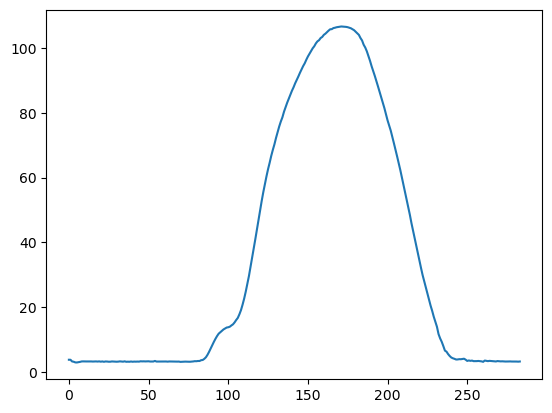

In [150]:
df_sto['knee_angle_r'].plot()

<Axes: >

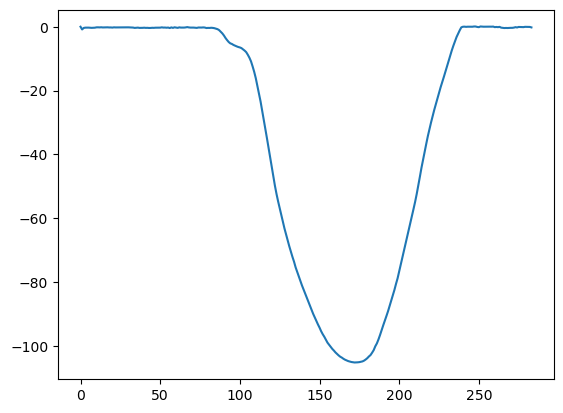

In [151]:
df_c3d['LKneeAngles_X'].plot()

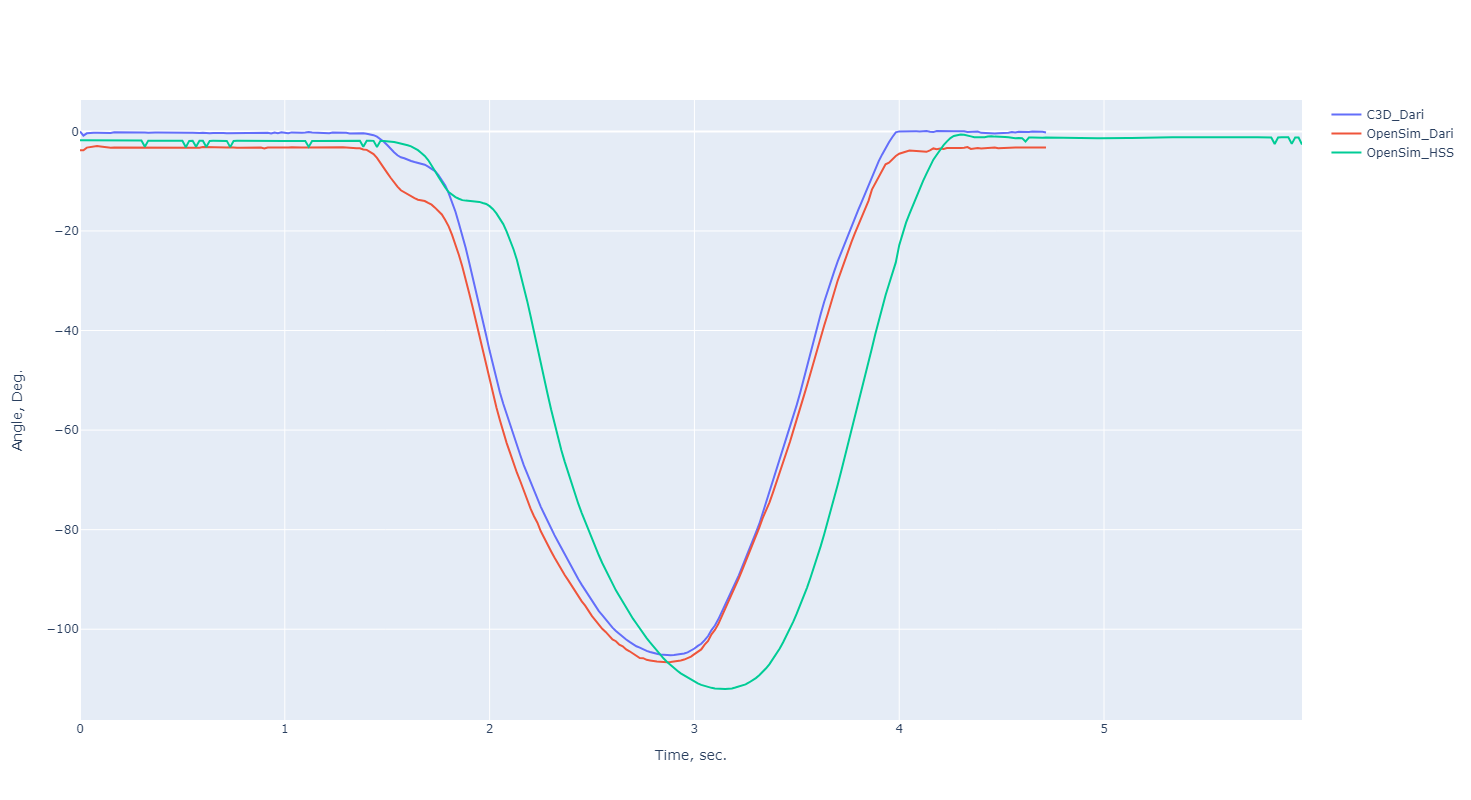

In [152]:
fig2 = sp.make_subplots(rows=1, cols=1)

fig2.add_trace(go.Scatter(x = df_c3d['Time'], y = df_c3d['LKneeAngles_X'], mode='lines', name='C3D_Dari'), row=1, col=1)

fig2.add_trace(go.Scatter(x = df_sto['time'], y = df_sto['knee_angle_r'] * -1.0, mode='lines', name='OpenSim_Dari'), row=1, col=1)

fig2.add_trace(go.Scatter(x = df_sto_hss['time'], y = df_sto_hss['knee_angle_r'] * -1.0, mode='lines', name='OpenSim_HSS'), row=1, col=1)


fig2.update_yaxes(title_text='Angle, Deg.', row=1, col=1)
fig2.update_xaxes(title_text='Time, sec.', row=1, col=1)

fig2.update_layout(
    autosize=False,
    width=1000,
    height=800,
)

fig2.show()

In [153]:
def plot_func(ang_dari, ang_osim, inverse1, inverse2):
    fig2 = sp.make_subplots(rows=1, cols=1)
    if inverse1:
        y1 = df_c3d[ang_dari] * -1.0
        y2 = df_sto[ang_osim]
    else:
        y1 = df_c3d[ang_dari]
        y2 = df_sto[ang_osim]
        
    fig2.add_trace(go.Scatter(x = df_c3d['Time'], y = y1, mode='lines', name='C3D_Dari'), row=1, col=1)
    if inverse2:

        y3 = df_sto_hss[ang_osim] * -1.0
    else:

        y3 = df_sto_hss[ang_osim]
    
    fig2.add_trace(go.Scatter(x = df_sto['time'], y = y2, mode='lines', name='OpenSim_Dari'), row=1, col=1)

    fig2.add_trace(go.Scatter(x = df_sto_hss['time'], y = y3, mode='lines', name='OpenSim_HSS'), row=1, col=1)
    
    fig2.update_yaxes(title_text='Angle, Deg.', row=1, col=1)
    fig2.update_xaxes(title_text='Time, sec.', row=1, col=1)
    
    fig2.update_layout(
        autosize=False,
        width=800,
        height=600,
    )
    
    fig2.show()

list1 = list(df_c3d.columns)[2:]

options1=widgets.Dropdown(
    options=list1,
    description='Ch_dari:',
    disabled=False,
)

list2 = list(df_sto.columns)[1:]

options2=widgets.Dropdown(
    options=list2,
    description='Ch_osim:',
    disabled=False,
)

options3=widgets.Dropdown(
    options=[False, True],
    description='Inverse_dari:',
    disabled=False,
)

options4=widgets.Dropdown(
    options=[False, True],
    description='Inverse_osim:',
    disabled=False,
)

interact(plot_func, ang_dari=options1, ang_osim=options2, inverse1=options3, inverse2=options4);

interactive(children=(Dropdown(description='Ch_dari:', options=('LeftUpLeg__X', 'LeftUpLeg__Y', 'LeftUpLeg__Z'…

In [154]:
angle_pairs = [ 
            ['RHipAngles_X','hip_flexion_r', 1, 0, 0],
            ['RHipAngles_Y','hip_rotation_r',0, 0, 0],
            ['RHipAngles_Z','hip_adduction_r',1, 0, 0],
            ['LHipAngles_X','hip_flexion_l',1, 0, 0],
            ['LHipAngles_Y','hip_rotation_l',0, 0, 0],
            ['LHipAngles_Z','hip_adduction_l',1, 0, 0],
            ['RKneeAngles_X','knee_angle_r',1, 0, 0],
            ['LKneeAngles_X','knee_angle_l',1, 0, 0],
            ['RAnkleAngles_X','ankle_angle_r',1, 0, 0],
            ['LAnkleAngles_X','ankle_angle_l',1, 0, 0],
            ]

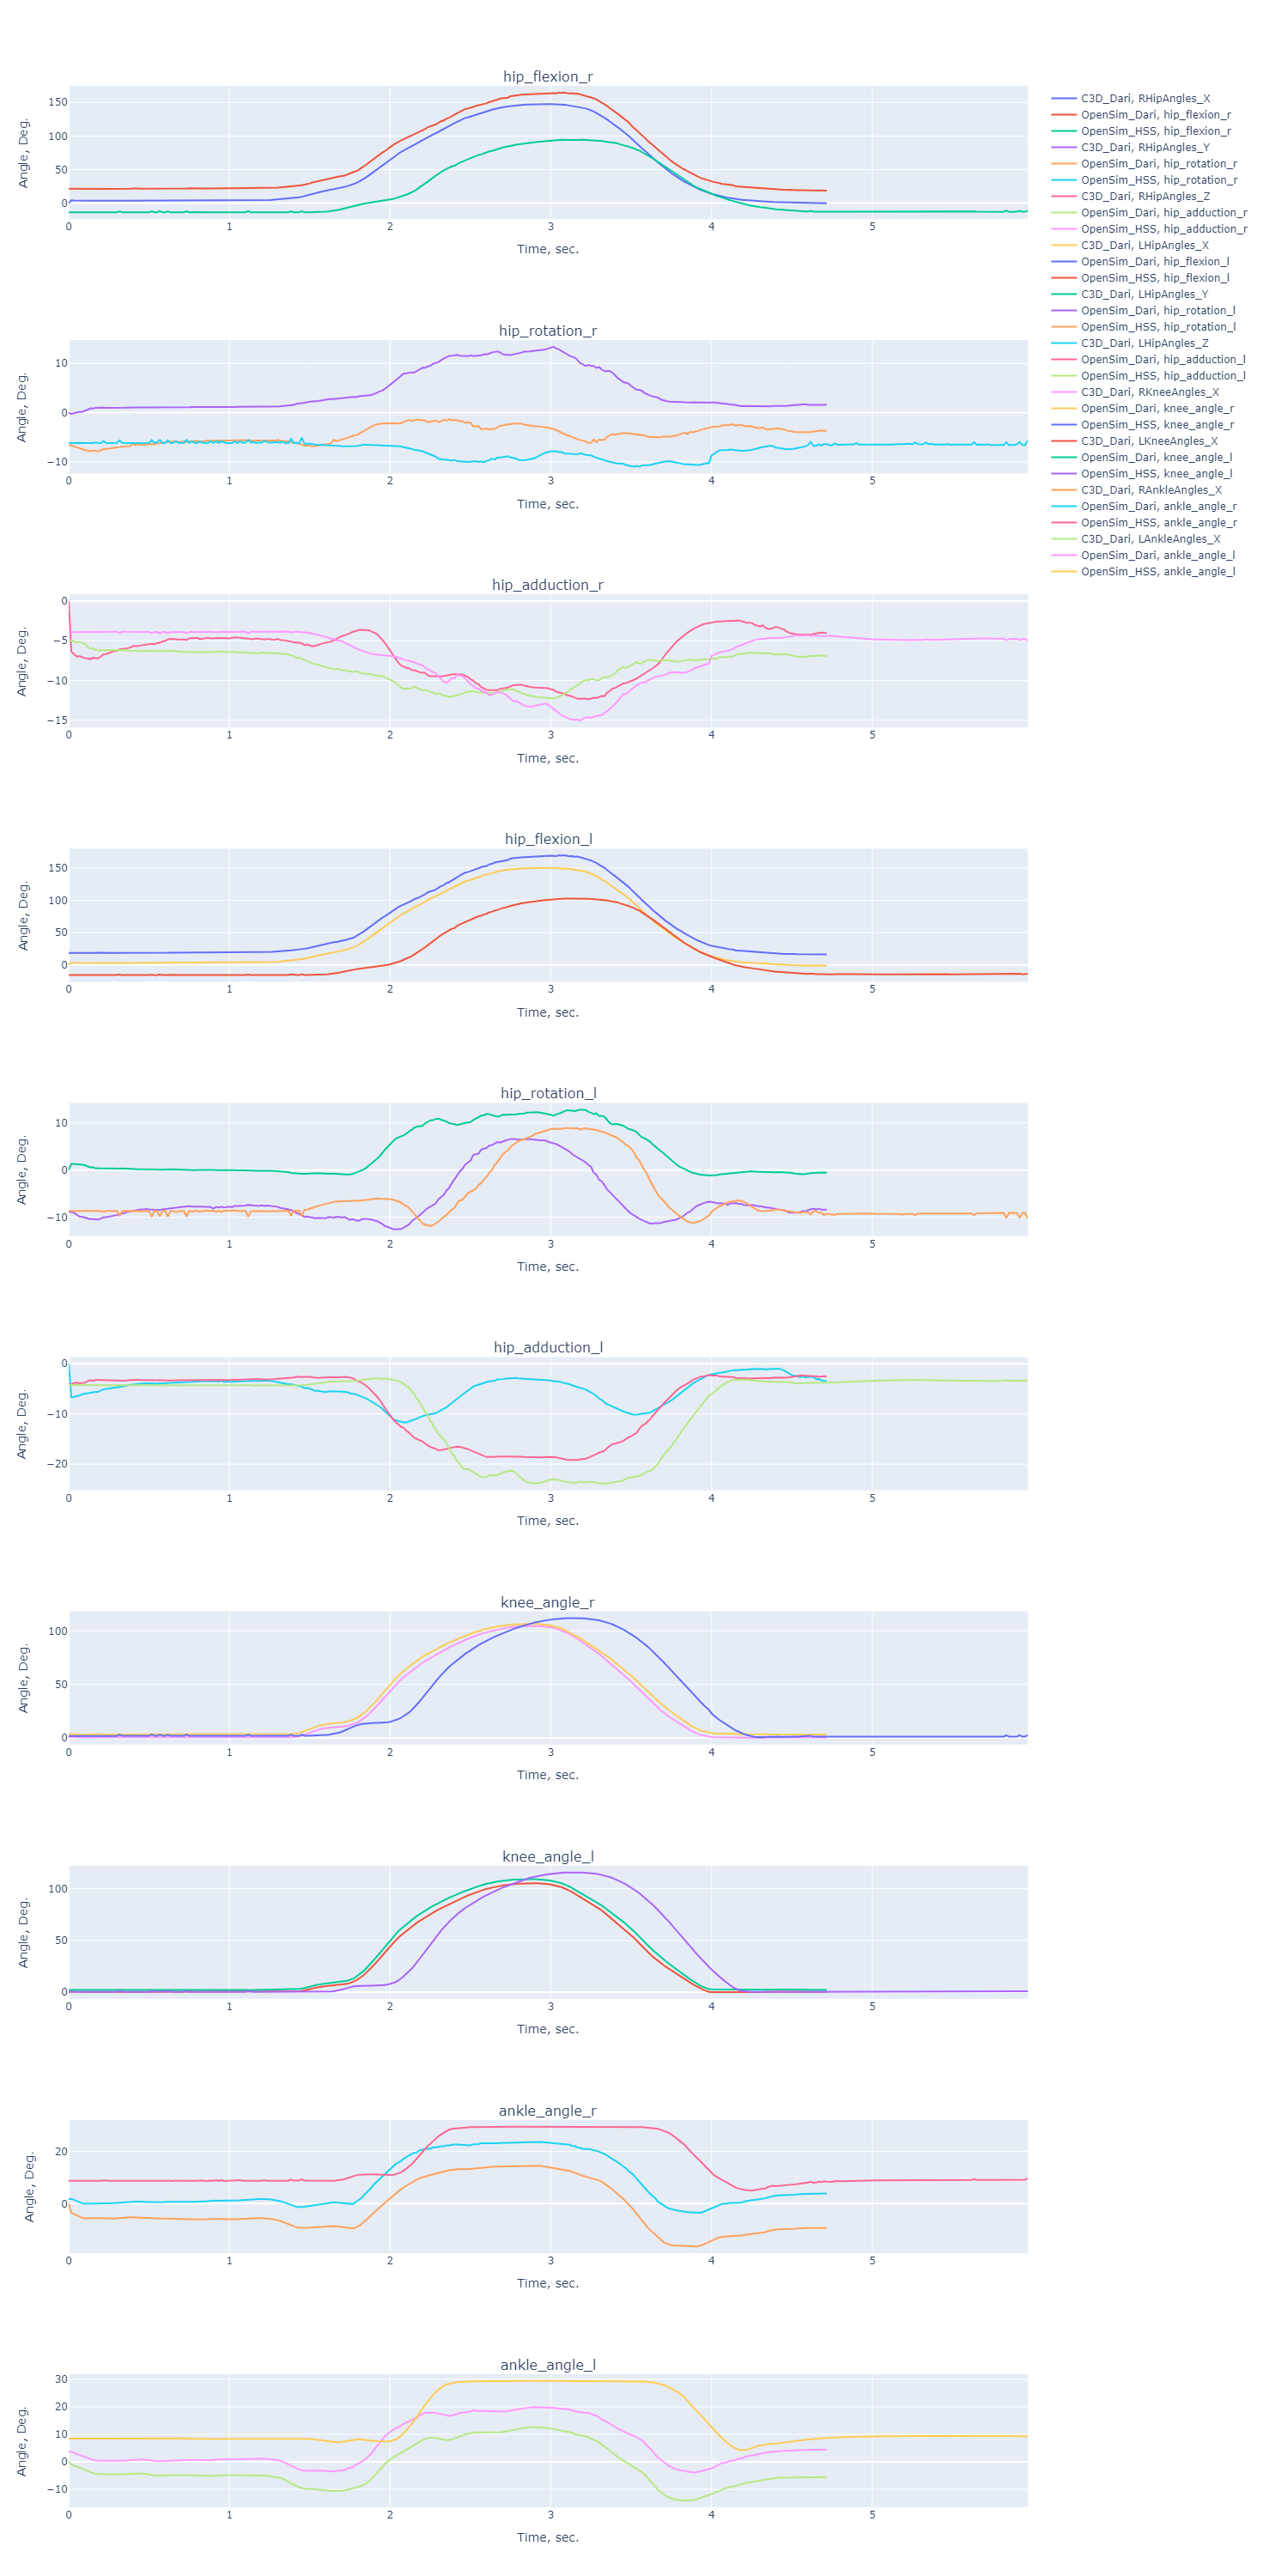

In [155]:
subplot_titles= [i[1] for i in angle_pairs]

fig2 = sp.make_subplots(rows=len(angle_pairs), cols=1, subplot_titles=subplot_titles)
rows =1

for i in angle_pairs:
    if i[2]:
        y_ = df_c3d[i[0]] * -1.0
    else:
        y_ = df_c3d[i[0]]   

    fig2.add_trace(go.Scatter(x = df_c3d['Time'], y = y_, mode='lines', name=f'C3D_Dari, {i[0]}'), row=rows, col=1)
    
    if i[3]:
        y_ = df_sto[i[1]] * -1.0
    else:
        y_ = df_sto[i[1]]  
    
    fig2.add_trace(go.Scatter(x = df_sto['time'], y = y_, mode='lines', name=f'OpenSim_Dari, {i[1]}'), row=rows, col=1)
    
    if i[4]:
        y_ = df_sto_hss[i[1]] * -1.0
    else:
        y_ = df_sto_hss[i[1]]
    
    fig2.add_trace(go.Scatter(x = df_sto_hss['time'], y = y_, mode='lines', name=f'OpenSim_HSS, {i[1]}'), row=rows, col=1)

    fig2.update_yaxes(title_text='Angle, Deg.', row=rows, col=1)
    
    fig2.update_xaxes(title_text='Time, sec.', row=rows, col=1)

    rows = rows +1




fig2.update_layout(
    autosize=False,
    width=1000,
    height=3000,
)

fig2.show()

## HSS to OpenSim comparison

In [42]:
hss_data_folder = 'Osim_test/HSS_DATA/'
hss_record = 'squat1'

In [43]:
records_type = 'walk' # squat or walk
index_list = ['1','2','3','4','5']

In [44]:
df_hss = pd.read_csv(hss_data_folder + f'{records_type}{index_list[4]}JointAngles.txt', header=[1, 4], delimiter='\t')

In [52]:
df_hss.columns

MultiIndex([('Unnamed: 0_level_0', 'ITEM'),
            (       'L_Hip_Angle',    'X'),
            (       'L_Hip_Angle',    'Y'),
            (       'L_Hip_Angle',    'Z'),
            (      'L_Knee_Angle',    'X'),
            (      'L_Knee_Angle',    'Y'),
            (      'L_Knee_Angle',    'Z'),
            (       'R_Hip_Angle',    'X'),
            (       'R_Hip_Angle',    'Y'),
            (       'R_Hip_Angle',    'Z'),
            (      'R_Knee_Angle',    'X'),
            (      'R_Knee_Angle',    'Y'),
            (      'R_Knee_Angle',    'Z'),
            (      'Pelvis_Angle',    'X'),
            (      'Pelvis_Angle',    'Y'),
            (      'Pelvis_Angle',    'Z'),
            (       'Trunk_Angle',    'X'),
            (       'Trunk_Angle',    'Y'),
            (       'Trunk_Angle',    'Z'),
            (     'L_Knee_Moment',    'X'),
            (     'L_Knee_Moment',    'Y'),
            (     'L_Knee_Moment',    'Z'),
            (     'R_Knee_Moment

In [46]:
df_sto_hss, header_json_str_hss = read_sto_and_header_to_json(f'IK_HSS_{records_type}{index_list[4]}.sto')

In [51]:
df_sto_hss.columns

Index(['time', 'pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
       'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
       'hip_rotation_r', 'knee_angle_r', 'knee_angle_r_beta', 'ankle_angle_r',
       'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l',
       'hip_rotation_l', 'knee_angle_l', 'knee_angle_l_beta', 'ankle_angle_l',
       'subtalar_angle_l', 'mtp_angle_l', 'lumbar_extension', 'lumbar_bending',
       'lumbar_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r',
       'elbow_flex_r', 'pro_sup_r', 'wrist_flex_r', 'wrist_dev_r',
       'arm_flex_l', 'arm_add_l', 'arm_rot_l', 'elbow_flex_l', 'pro_sup_l',
       'wrist_flex_l', 'wrist_dev_l'],
      dtype='object')

In [126]:
angle_pairs = (['L_Knee_Angle','X','knee_angle_l'],
               ['R_Hip_Angle','X','hip_flexion_r'],
               ['R_Hip_Angle','Y','hip_adduction_r'],
               ['R_Hip_Angle','Z','hip_rotation_r'],
               ['Pelvis_Angle','Y','pelvis_tilt'],
               ['Pelvis_Angle','Z','pelvis_list'],
              ['Pelvis_Angle','X','pelvis_rotation'])

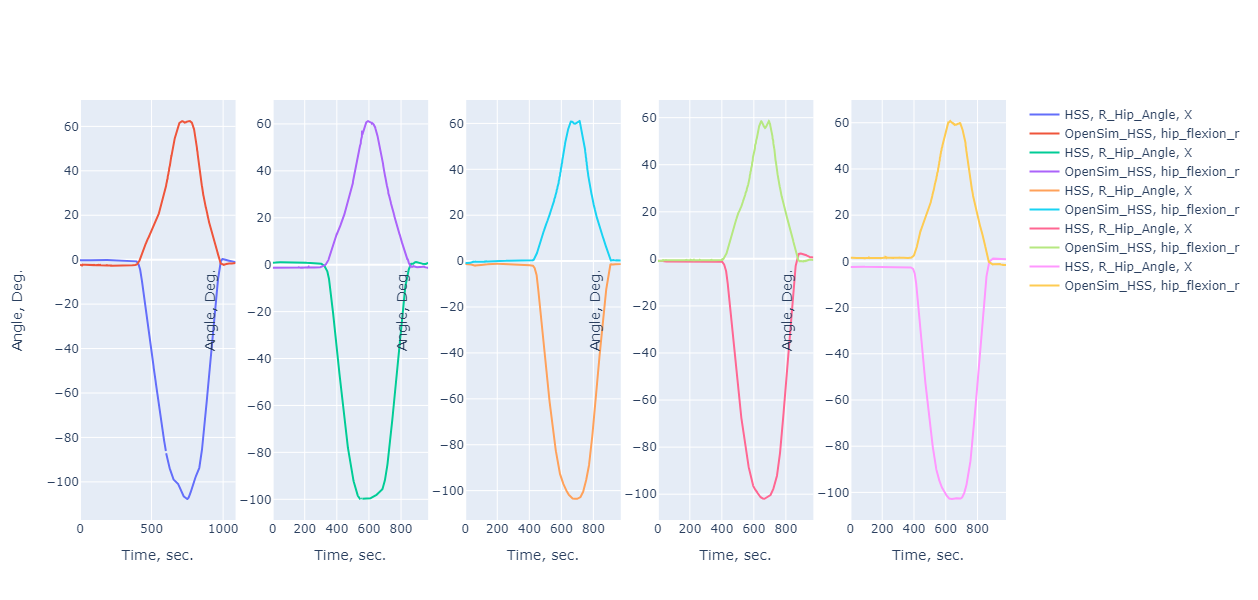

In [133]:
ch= angle_pairs[1]
fig2 = sp.make_subplots(rows=1, cols=5)

for i in index_list:

    df_hss = pd.read_csv(hss_data_folder + f'{records_type}{i}JointAngles.txt', header=[1, 4], delimiter='\t')

    df_sto_hss, header_json_str_hss = read_sto_and_header_to_json(f'IK_HSS_{records_type}{i}.sto')

    fig2.add_trace(go.Scatter(x = df_hss.index, y = df_hss[ch[0],ch[1]] * -1.0, mode='lines', name=f'HSS, {ch[0]}, {ch[1]}'), row=1, col=int(i))
    
    #fig2.add_trace(go.Scatter(x = df_sto['time'], y = df_sto['knee_angle_r'] * -1.0, mode='lines', name='OpenSim_Dari'), row=1, col=1)
    
    fig2.add_trace(go.Scatter(x = df_sto_hss.index, y = df_sto_hss[ch[2]], mode='lines', name=f'OpenSim_HSS, {ch[2]}'), row=1, col=int(i))
    
    
    fig2.update_yaxes(title_text='Angle, Deg.', row=1, col=int(i))
    
    fig2.update_xaxes(title_text='Time, sec.', row=1, col=int(i))
    
    fig2.update_layout(
        autosize=False,
        width=1300,
        height=600,
    )

fig2.show()

In [131]:
records_type = 'squat' # squat or walk

In [129]:
#df_hss.columns

In [132]:
options5=widgets.Dropdown(
    options=list(range(len(angle_pairs))),
    description='Angles:',
    disabled=False,
)

def func_plot(opt):

    ch= angle_pairs[opt]

    print(ch)
    
    fig2 = sp.make_subplots(rows=1, cols=5)

    for i in index_list:
    
        df_hss = pd.read_csv(hss_data_folder + f'{records_type}{i}JointAngles.txt', header=[1, 4], delimiter='\t')
    
        df_sto_hss, header_json_str_hss = read_sto_and_header_to_json(f'IK_HSS_{records_type}{i}.sto')
    
        fig2.add_trace(go.Scatter(x = df_hss.index, y = df_hss[ch[0],ch[1]] * -1.0, mode='lines', name=f'HSS, {ch[0]} {ch[1]}'), row=1, col=int(i))
        
        #fig2.add_trace(go.Scatter(x = df_sto['time'], y = df_sto['knee_angle_r'] * -1.0, mode='lines', name='OpenSim_Dari'), row=1, col=1)
        
        fig2.add_trace(go.Scatter(x = df_sto_hss.index, y = df_sto_hss[ch[2]], mode='lines', name=f'OpenSim_HSS, {ch[2]}'), row=1, col=int(i))
        
        
        fig2.update_yaxes(title_text='Angle, Deg.', row=1, col=int(i))
        fig2.update_xaxes(title_text='Time, sec.', row=1, col=int(i))
        
        fig2.update_layout(
            autosize=False,
            width=1300,
            height=600,
        )
    
    fig2.show()

interact(func_plot, opt=options5);

interactive(children=(Dropdown(description='Angles:', options=(0, 1, 2, 3, 4, 5, 6), value=0), Output()), _dom…

In [118]:
list(range(len(angle_pairs)))

[0, 1, 2, 3, 4, 5, 6]